Epoch : 1  Loss: 171.9421
Epoch : 2  Loss: 123.0500
Epoch : 3  Loss: 113.9641
Epoch : 4  Loss: 109.8127
Epoch : 5  Loss: 107.4168
Epoch : 6  Loss: 105.8524
Epoch : 7  Loss: 104.6964
Epoch : 8  Loss: 103.9035
Epoch : 9  Loss: 103.2009
Epoch : 10  Loss: 102.6982
Epoch : 11  Loss: 102.2390
Epoch : 12  Loss: 101.7986
Epoch : 13  Loss: 101.4510
Epoch : 14  Loss: 101.1938
Epoch : 15  Loss: 100.8834
Epoch : 16  Loss: 100.6407
Epoch : 17  Loss: 100.4331
Epoch : 18  Loss: 100.2438
Epoch : 19  Loss: 100.0096
Epoch : 20  Loss: 99.8496


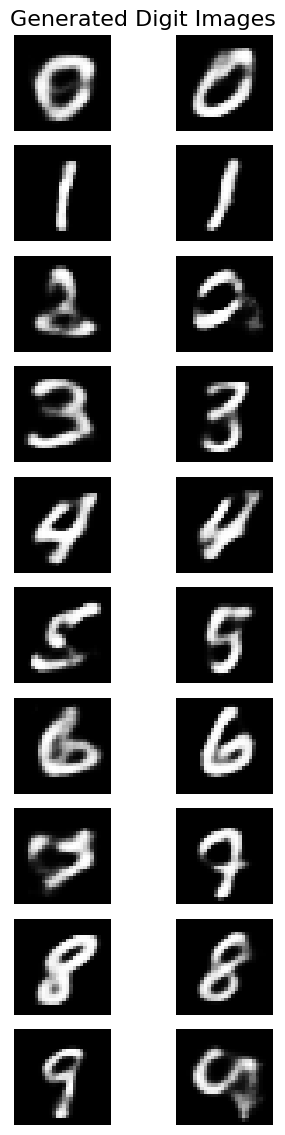

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
z1_dim = 32 # Dimensionality of latent variable z1
z2_dim = 16 # Dimensionality of latent variable z2
label_embed_dim = 16 # Embedding dimension for labels
hidden_dim = 256 # Hidden layer dimension for MLP layers

# One-hot encoding for labels
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

# Hierarchical VAE with conditioning on labels
class HierarchicalVAE(nn.Module):
    def __init__(self):
        super(HierarchicalVAE, self).__init__()
        # Embedding layer for one-hot encoded labels (10 classes)
        self.label_embed = nn.Linear(10, label_embed_dim)  # Embed labels
        
        # Encoder
        self.enc_fc = nn.Linear(784 + label_embed_dim, hidden_dim)  # Flattened image + label embedding
        
        # Top-level latent
        self.enc_fc_z2 = nn.Linear(hidden_dim, 2 * z2_dim)  # Outputs both mu and logvar for z2
        
        # Second-level latent
        self.enc_fc_z1 = nn.Linear(hidden_dim + z2_dim + label_embed_dim, 2 * z1_dim)  # Compute mu and logvar for z1
        
        # Prior for z1 conditioned on z2 and label
        self.prior_fc = nn.Linear(z2_dim + label_embed_dim, 2 * z1_dim)  # Prior parameters for z1
        
        # Decoder
        self.dec_fc1 = nn.Linear(z1_dim + z2_dim + label_embed_dim, hidden_dim)  # Hidden layer for decoder
        self.dec_fc2 = nn.Linear(hidden_dim, 784)  # Final layer to reconstruct flattened image
        
    def encode(self, x, y):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        # One-hot encode labels
        y_onehot = one_hot(y)
        y_emb = F.relu(self.label_embed(y_onehot))
        # Pass through encoder fully connected layer
        h = F.relu(self.enc_fc(torch.cat([x, y_emb], dim=1)))
        
        # Parameters for z2 from hidden representation
        stats_z2 = self.enc_fc_z2(h)
        mu_z2, logvar_z2 = stats_z2.chunk(2, dim=1)  # Split into mean and log variance for z2
        # Sample z2 from the Gaussian using reparameterization
        std_z2 = torch.exp(0.5 * logvar_z2)
        eps_z2 = torch.randn_like(std_z2)
        z2 = mu_z2 + eps_z2 * std_z2
        
        # Concatenate h, z2, and label embedding for computing parameters of z1
        h_z1 = torch.cat([h, z2, y_emb], dim=1)
        stats_z1 = self.enc_fc_z1(h_z1)
        mu_z1, logvar_z1 = stats_z1.chunk(2, dim=1)  # Split into mean and log variance for z1
        std_z1 = torch.exp(0.5 * logvar_z1)
        eps_z1 = torch.randn_like(std_z1)
        z1 = mu_z1 + eps_z1 * std_z1
        return (mu_z1, logvar_z1, z1), (mu_z2, logvar_z2, z2), y_emb
    
    def prior(self, z2, y_emb):
        # Compute prior parameters for z1 conditioned on z2 and label embedding
        stats = self.prior_fc(torch.cat([z2, y_emb], dim=1))
        mu_prior, logvar_prior = stats.chunk(2, dim=1)
        return mu_prior, logvar_prior
    
    def decode(self, z1, z2, y_emb):
        h_dec = F.relu(self.dec_fc1(torch.cat([z1, z2, y_emb], dim=1)))
        x_recon_logits = self.dec_fc2(h_dec)  # Get logits for each pixel
        x_recon = torch.sigmoid(x_recon_logits)  # Apply sigmoid to get pixel values between 0 and 1
        return x_recon
    
    def forward(self, x, y):
        # Encode input to obtain latent variables and label embedding
        (mu_z1, logvar_z1, z1), (mu_z2, logvar_z2, z2), y_emb = self.encode(x, y)
        # Compute the prior for z1 based on z2 and label embedding
        mu_prior, logvar_prior = self.prior(z2, y_emb)
        # Decode latent variables back to image
        x_recon = self.decode(z1, z2, y_emb)
        return x_recon, (mu_z1, logvar_z1), (mu_z2, logvar_z2), (mu_prior, logvar_prior)

# Loss function (reconstruction loss + KL divergence)
def loss_fn(x, x_recon, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_prior, logvar_prior):
    # Flatten original images
    x = x.view(x.size(0), -1)
    # Reconstruction loss using binary cross entropy over all pixels
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    
    # KL divergence for z2
    kl_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp())
    
    # KL divergence for z1
    kl_z1 = -0.5 * torch.sum(1 + logvar_z1 - logvar_prior - ((mu_z1 - mu_prior).pow(2) + logvar_z1.exp())/logvar_prior.exp().clamp(min=1e-8))
    
    return recon_loss + kl_z1 + kl_z2

# Loading the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = HierarchicalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)  # Adam optimizer

# Training loop
epochs = 20
model.train()
for epoch in range(1, epochs + 1):  # Loop over epochs
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):  # Iterate over batches
        data = data.to(device)    # Move data to GPU
        labels = labels.to(device)  # Move labels to GPU
        optimizer.zero_grad()  # Zero out gradients before backpropagation
        x_recon, (mu_z1, logvar_z1), (mu_z2, logvar_z2), (mu_prior, logvar_prior) = model(data, labels)  # Forward pass
        loss = loss_fn(data, x_recon, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_prior, logvar_prior)  # Compute loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()  # Accumulate loss
        optimizer.step()  # Update weights
    print(f"Epoch : {epoch}  Loss: {train_loss / len(train_loader.dataset):.4f}")

# Image Generation
model.eval()  # Set model to evaluation mode
generated_images = []  # To store images
generated_labels = []  # To store labels
with torch.no_grad():  # Disable gradient calculation for generation
    for digit in range(10):  # Loop over digit classes
        # Create a batch of labels for the current digit
        labels = torch.full((2,), digit, dtype=torch.long, device=device)
        y_onehot = one_hot(labels)  # One-hot encode labels
        y_emb = F.relu(model.label_embed(y_onehot))  # Get label embedding
        # Sample z2 from standard normal distribution
        z2 = torch.randn(n_gen, z2_dim, device=device)
        # Compute prior parameters for z1 based on z2 and label embedding
        mu_prior, logvar_prior = model.prior(z2, y_emb)
        std_prior = torch.exp(0.5 * logvar_prior)
        eps = torch.randn_like(std_prior)
        z1 = mu_prior + eps * std_prior  # Sample z1 using reparameterization trick
        # Decode the latent variables to generate images
        x_gen = model.decode(z1, z2, y_emb)

        x_gen = x_gen.view(-1, 28, 28).cpu().numpy()
        generated_images.append(x_gen)
        generated_labels.extend([digit] * n_gen)

# Plotting the images
fig, axes = plt.subplots(10, n_gen, figsize=(n_gen * 2, 12))
for i in range(10):
    imgs = generated_images[i]
    for j in range(n_gen):
        ax = axes[i, j]
        ax.imshow(imgs[j], cmap='gray')
        ax.axis('off')

plt.suptitle("Generated Digit Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()
